# References
Neural Style Transfer Gatys: https://arxiv.org/pdf/1508.06576.pdf 

LapStyle: https://arxiv.org/pdf/1707.01253.pdf

# Перевод стиля изображения. Алгоритм Гатиса.

Преобразует полученное на вход изображение в соответствии с выбранным стилем. Алгоритм берет два изображения:

-Изображение контента (англ. Content Image), в котором нас интересует содержание. Обычно оно является фотографией.

-Изображение стиля (англ. Style Image), в котором нас интересует художественный стиль (цветовое наполнение, текстуры и т.д.). Обычно изображением стиля являются картины известных художников.

Затем алгоритм изменяет входные данные так, чтобы они соответствовали содержанию изображения контента и художественному стилю изображения стиля.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
from io import BytesIO
from torch import optim

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [ ]:
def deprocess_img(img): # channels first
    img[0, :, :] *= 0.229
    img[1, :, :] *= 0.224
    img[2, :, :] *= 0.225

    img[0, :, :] += 0.485
    img[1, :, :] += 0.456
    img[2, :, :] += 0.406

    return img

Saving img.jpg to img.jpg
Saving img_style.jpg to img_style.jpg


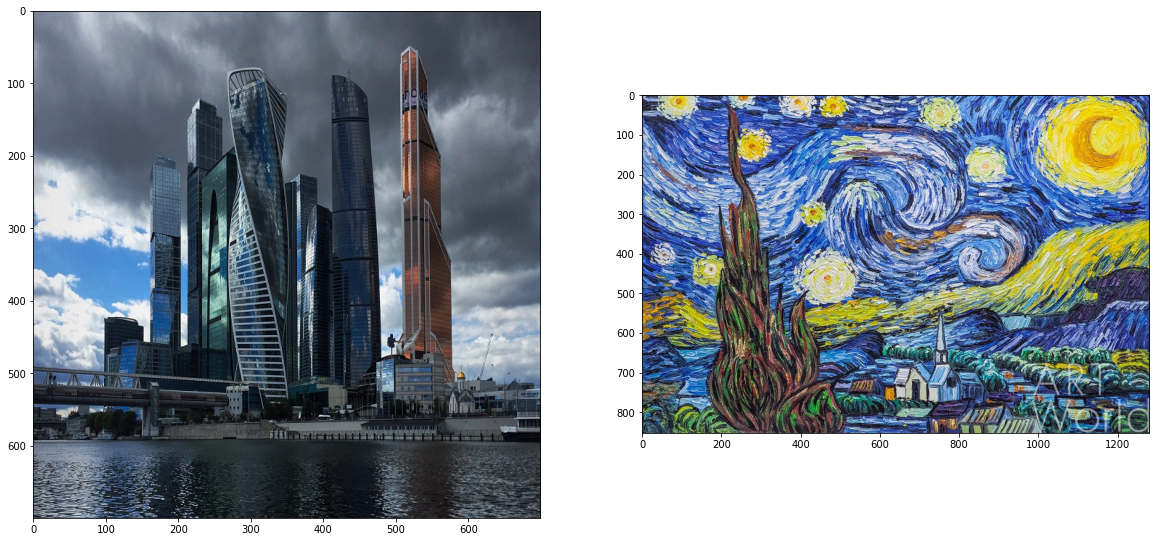

In [ ]:
upl = files.upload()
img = Image.open(BytesIO(upl['img.jpg']))
img_style = Image.open(BytesIO(upl['img_style.jpg']))
fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
plt.imshow( img )
plt.subplot(1, 2, 2)
plt.imshow( img_style )
plt.show()



mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])


img = transform(img).to(device)
img_style = transform(img_style).to(device)
img = img.unsqueeze(0)
img_style = img_style.unsqueeze(0)

In [ ]:
vgg16 = models.vgg16(pretrained=True).features.to(device)
for p in vgg16.parameters():
    p.requires_grad = False

content_layer = [29]
style_layers = [1, 6, 11, 18, 25]
output_layers = content_layer + style_layers    

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


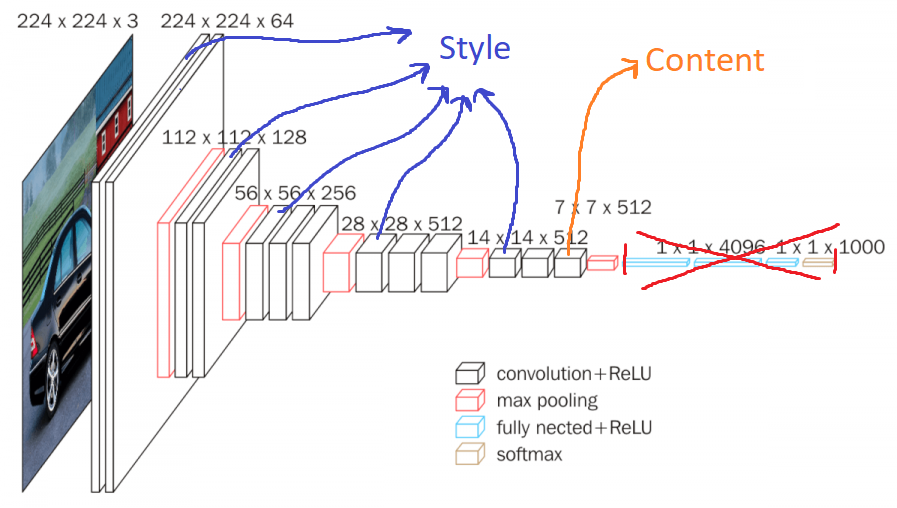

In [ ]:
print(vgg16)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

## Функция для вычисления матрицы Грама.



Мы получаем на вход некоторый тензор, затем вытягиваем его в двухмерную матрицу:

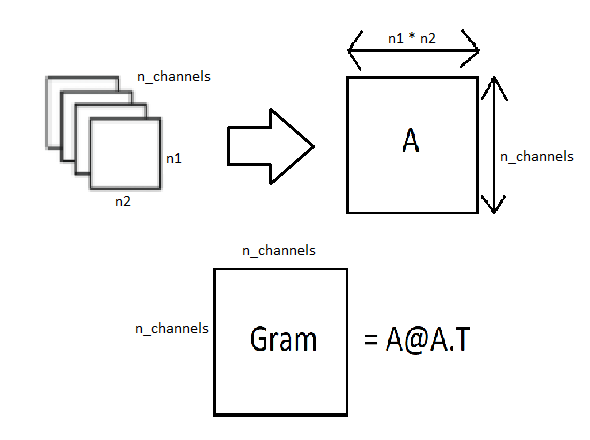


Затем умножаем эту матрицу саму на себу транспонированную.



In [ ]:
def gram_matrix(input):
    a, ch, h, w = input.size()
    features = input.view(a * ch, h * w)
    G = torch.mm(features, features.t())
    return G.div(a * ch * h * w)
    

class Vgg16(torch.nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        features = list(vgg16)
        self.features = nn.ModuleList(features).eval() 

    def forward(self, x):
        results = []
        for ii,model in enumerate(self.features):
            x = model(x)
            if ii in output_layers:
                results.append(x)
        return results      

In [ ]:
model = Vgg16()

# get style and content targets
content_t = model(img)[-1]
style_ = model(img_style)[:-1]
style_t = []
for st in style_:
    style_t.append(gram_matrix(st))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)





## Функции потерь по контенту и по стилю.

---




Функция потерь для контента:



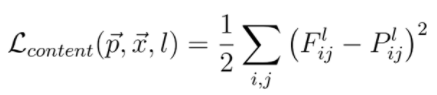


Потеря контента, генерируемая на уровне l сети, относительно изображения p контента и изображения x оптимизации, представляет собой среднеквадратичную разницу между каждым представлением контента и активацией p и x на уровне l.

Функция потерь для стиля:


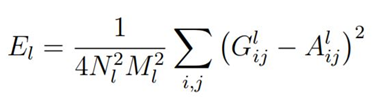

Здесь мы перебираем грамм-матрицу изображения оптимизации (G) и грамм-матрицу образа стиля (A). Суммируем квадратную разницу между всеми элементами этих двух матриц. Здесь N представляет количество карт объектов в слое l, а M представляет количество элементов в этих N картах объектов. Затем сумма масштабируется в 4 раза N² * M² для окончательной потери стиля для слоя l.

Функция для вычисления суммарного лосса по стилю.




В статье Гатиса говорится, что наилучшие результаты достигаются при сравнении стиля изображений на нескольких слоях. Таким образом, общая потеря стиля составляет:


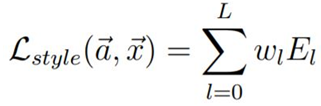



Где w (l) представляет вес для потерь в слое l, а E (l) представляет собой потерю в слое l.

Итоговая функция потерь

---

Total_loss = content_weight * L_content + style_weight * L_style

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


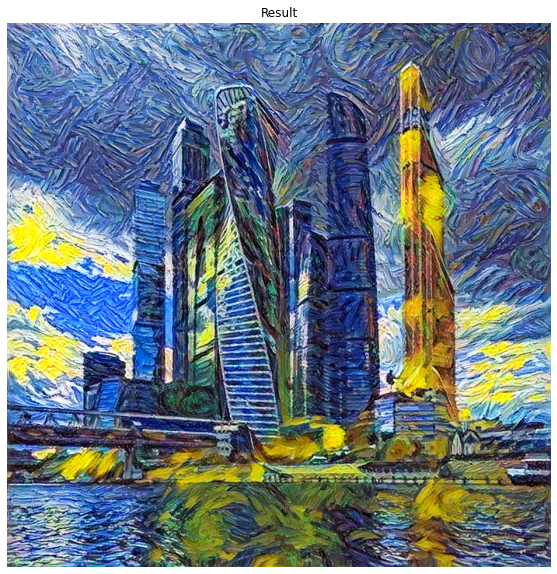

In [ ]:
criterion = nn.MSELoss()

out_image = torch.tensor(img, requires_grad=True)
#optimizer = optim.Adam([out_image], lr=0.1)
optimizer = optim.LBFGS([out_image])

iter_num = 20
content_weight, style_weight = 1e-20, 1e+20

for i in range(iter_num):
    print(i)
    def closure():
        optimizer.zero_grad()
        out = model(out_image)

        content_loss = criterion(out[-1], content_t)

        style_loss = 0
        for style_layer, target_style in zip(out[:-1], style_t):
            style_loss += criterion(gram_matrix(style_layer), target_style)
        style_loss /= len(style_t)

        loss = style_loss * style_weight + content_loss * content_weight
        # print('iter: %d, loss: %d' % (i, loss.item()))

        loss.backward()
        return loss

    optimizer.step(closure)  


out_image = deprocess_img(out_image.detach().squeeze().cpu())
#result = out_image.detach().squeeze().cpu()
out_image = out_image.permute(1, 2, 0)

fig = plt.figure(figsize=(10, 10))
plt.title('Result')
plt.axis('off')
plt.imshow(torch.clip(out_image, min=0, max=1))  
plt.show()

# Гатис и LapStyle

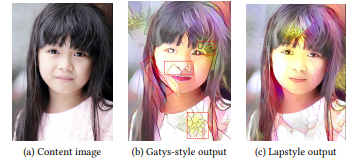

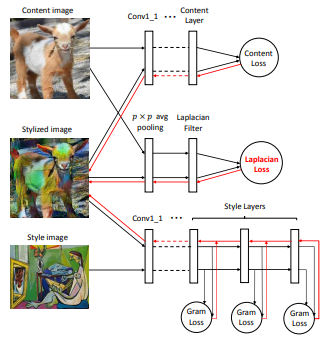

In [ ]:
class LapStyle(torch.nn.Module):
    def __init__(self):
        super(LapStyle, self).__init__()
        self.avg_pool = nn.AvgPool2d(3, stride=3)
        self.laplacian_filter = nn.Conv2d(3, 3, 3, 1, bias=False)
        laplacian = torch.tensor([[[0.,-1.,0.],
                                  [-1.,4.,-1.],
                                  [0.,-1.,0.]],
                                  [[0.,-1.,0.],
                                  [-1.,4.,-1.],
                                  [0.,-1.,0.]],
                                  [[0.,-1.,0.],
                                  [-1.,4.,-1.],
                                  [0.,-1.,0.]],
                                  ])
        laplacian = laplacian.unsqueeze(0)
        self.laplacian_filter.weight = nn.Parameter(laplacian)
        self.laplacian_filter.weight.requires_grad = False

        features = list(vgg16)
        self.features = nn.ModuleList(features).eval() 

    def forward(self, input):
        results = []

        x = input.clone()
        for ii,model in enumerate(self.features):
            x = model(x)
            if ii in output_layers:
                results.append(x)
        
        x = input.clone()
        x = self.avg_pool(x)
        x = self.laplacian_filter(x)
        results.append(x)
        return results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


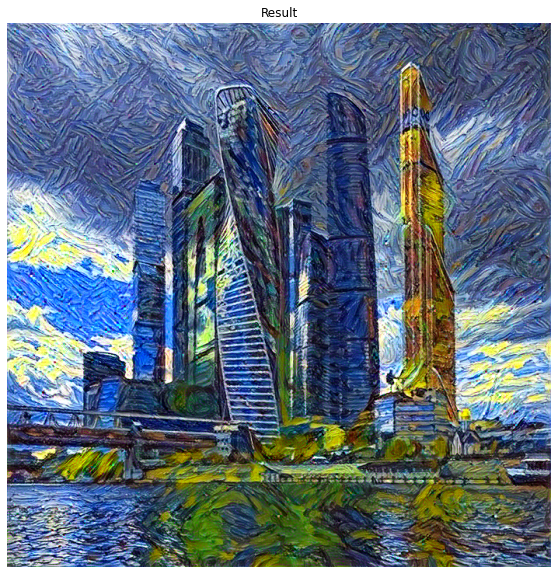

In [ ]:
lap_out_image = torch.tensor(img, requires_grad=True)
# optimizer = optim.Adam([lap_out_image], lr=0.1)
optimizer = optim.LBFGS([lap_out_image])
model = LapStyle().to(device)

lap_target = model(lap_out_image)[-1]

iter_num = 20
content_weight, style_weight, lap_weight = 1e-20, 1e+20, 1e+20

for i in range(iter_num):
    # lap_out_image.data.clamp_(0, 1)
    print(i)
    def closure():
        optimizer.zero_grad()
        out = model(lap_out_image)

        content_loss = criterion(out[-2], content_t)

        style_loss = 0
        for style_layer, target_style in zip(out[:-2], style_t):
            style_loss += criterion(gram_matrix(style_layer), target_style)
        style_loss /= len(style_t)

        lap_loss = criterion(out[-1], lap_target)

        loss = style_loss * style_weight + content_loss * content_weight + lap_loss * lap_weight
      
        loss.backward(retain_graph=True)

        return loss

    optimizer.step(closure)  


lap_out_image = deprocess_img(lap_out_image.detach().squeeze().cpu())
lap_out_image = lap_out_image.permute(1, 2, 0)

fig = plt.figure(figsize=(10, 10))
plt.title('Result')
plt.axis('off')
plt.imshow(torch.clip(lap_out_image, min=0, max=1))  
plt.show()

# Сравнение результатов
не нажимать!

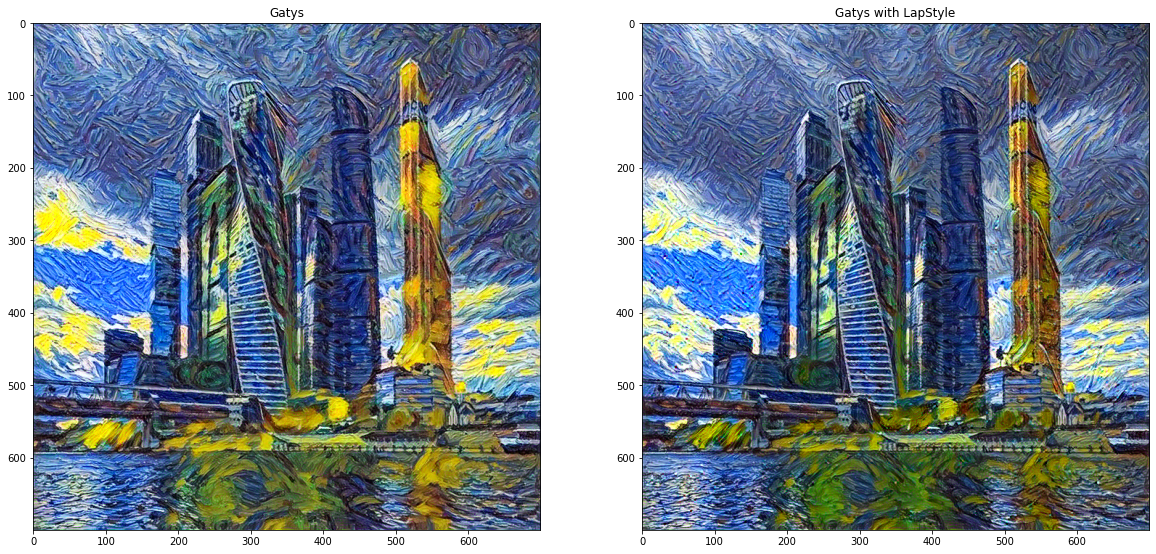

In [ ]:
fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
plt.title('Gatys')
plt.imshow(torch.clip(out_image, min=0, max=1))
plt.subplot(1, 2, 2)
plt.title('Gatys with LapStyle')
plt.imshow(torch.clip(lap_out_image, min=0, max=1))
plt.show()
